In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, SAGEConv
from torch_geometric.data import Data
from torch_geometric.nn import global_mean_pool
import torch_scatter

import numpy as np
from sklearn.metrics import ndcg_score
from collections import defaultdict
import pandas as pd

from pathlib import Path

### Load Data

In [2]:
project_root = Path("C://Users//DELL//Desktop//the-year-25-26//scalable-graph-based-movie-recommender")

In [3]:
ratings = pd.read_csv(project_root / 'data' / 'processed' / 'ratings_gnn.csv')
ratings.head()

,userId,movieId,rating,timestamp
0,1,1,4.0,1225734739
1,1,110,4.0,1225865086
2,1,158,4.0,1225733503
3,1,260,4.5,1225735204
4,1,356,5.0,1225735119


In [4]:
movies = pd.read_csv(project_root / 'data' / 'processed' / 'movies_gnn.csv')
movies.head()

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance
3,4,Waiting to Exhale (1995),Comedy|Drama|Romance
4,5,Father of the Bride Part II (1995),Comedy


In [5]:
tags = pd.read_csv(project_root / 'data' / 'processed' / 'tags_gnn.csv')
tags.head()

,userId,movieId,tag,timestamp
0,302,3863,atmospheric,1476691609
1,302,3863,beautiful cinematography,1476691614
2,302,3863,stylized,1476691602
3,302,4226,great ending,1476691644
4,302,4226,psychological,1476691635


In [6]:
genome_scores= pd.read_csv(project_root / 'data' / 'processed' / 'genome_scores_gnn.csv')
genome_scores.head()

,movieId,tagId,relevance
0,1,1,0.03200
1,1,2,0.02225
2,1,3,0.07000
3,1,4,0.05900
4,1,5,0.12300


In [7]:
genome_tags= pd.read_csv(project_root / 'data' / 'processed' / 'genome_tags_gnn.csv')
genome_tags.head()

,tagId,tag
0,1,007
1,2,007 (series)
2,3,18th century
3,4,1920s
4,5,1930s


### Data Preprocessing

In [8]:
user_ids = ratings['userId'].unique()
movie_ids = ratings['movieId'].unique()
num_users = len(user_ids)
num_movies = len(movie_ids)

# Map original IDs to continuous indices
user_mapping = {id: idx for idx, id in enumerate(user_ids)}
movie_mapping = {id: idx for idx, id in enumerate(movie_ids)}

ratings['user_idx'] = ratings['userId'].map(user_mapping)
ratings['movie_idx'] = ratings['movieId'].map(movie_mapping)

In [9]:
# Filter content data
tags_filtered = tags[tags['movieId'].isin(movie_ids)]
genome_scores_filtered = genome_scores[genome_scores['movieId'].isin(movie_ids)]

# Create content features (reduce genome dimensionality)
from scipy.sparse import csc_matrix
genome_matrix = csc_matrix(
    (genome_scores_filtered['relevance'].values,
     (genome_scores_filtered['movieId'].map(movie_mapping).values,
      genome_scores_filtered['tagId'].values)),
    shape=(num_movies, genome_tags['tagId'].max() + 1)
).toarray()

genome_matrix

array([[0.     , 0.032  , 0.02225, ..., 0.033  , 0.077  , 0.01825],
       [0.     , 0.0525 , 0.031  , ..., 0.08975, 0.0895 , 0.0235 ],
       [0.     , 0.03275, 0.04125, ..., 0.008  , 0.10025, 0.01475],
       ...,
       [0.     , 0.02975, 0.03075, ..., 0.0065 , 0.106  , 0.0165 ],
       [0.     , 0.03125, 0.03425, ..., 0.00575, 0.087  , 0.01175],
       [0.     , 0.04125, 0.044  , ..., 0.00625, 0.1225 , 0.01775]],
      shape=(5979, 1129))

In [10]:
# Reduce genome features to 64 dimensions
from sklearn.decomposition import PCA
pca = PCA(n_components=64)
genome_features_reduced = pca.fit_transform(genome_matrix)
movie_content_features = torch.tensor(genome_features_reduced, dtype=torch.float)
movie_content_features

tensor([[ 7.9723e-01,  1.0766e+00,  3.0914e+00,  ...,  1.6983e-02,
         -1.2054e-01, -3.0303e-01],
        [ 3.4215e+00,  2.6226e+00,  3.4195e+00,  ..., -4.3091e-02,
         -2.0517e-01, -1.4024e-01],
        [-2.0368e+00, -5.4134e-01,  1.1547e+00,  ...,  3.3427e-01,
         -1.7929e-03,  8.5898e-02],
        ...,
        [ 2.4176e-01, -1.2308e+00, -5.9882e-01,  ...,  1.0249e-01,
         -2.8139e-02, -7.4315e-02],
        [-1.8002e+00, -9.2147e-01,  1.5571e-02,  ..., -1.3791e-01,
         -3.1689e-02, -1.0051e-01],
        [-1.3067e+00, -4.0330e-01, -9.0030e-01,  ...,  1.2567e-01,
         -2.4711e-02, -2.4917e-01]])

In [11]:
# Create features for both users and movies with same dimension
base_features = torch.randn(num_users + num_movies, 64)
user_features = base_features[:num_users]  # 64-dim users
movie_features = base_features[num_users:] + 0.1 * movie_content_features  # 64-dim movies with content bias

# Combine features (same dimension for both)
x = torch.cat([user_features, movie_features], dim=0)  # [num_users + num_movies, 64]
x

tensor([[ 1.4693, -0.3254, -1.2363,  ...,  0.3584, -0.1869,  0.7489],
        [ 0.8610, -2.6513, -0.5243,  ..., -1.7881,  1.1241,  0.0545],
        [-1.5152,  1.1200, -0.7839,  ...,  0.0970,  0.0226,  1.2696],
        ...,
        [ 0.2002,  0.2790, -0.2396,  ..., -0.5096,  1.0717,  0.4233],
        [ 0.7661, -1.3194,  0.4646,  ..., -0.1851, -1.7069, -0.3196],
        [ 0.8311,  0.8889,  0.2065,  ..., -0.2393, -0.7104,  0.0590]])

### Create Bipartite Graph

In [12]:
# Create a bipartite graph
user_idx = ratings['user_idx'].values
movie_idx = ratings['movie_idx'].values + num_users

edge_index_np = np.column_stack([
    np.concatenate([user_idx, movie_idx]),
    np.concatenate([movie_idx, user_idx])
]).T

edge_index = torch.from_numpy(edge_index_np)
ratings_tensor = torch.tensor(ratings['rating'].values, dtype=torch.float)
edge_attr = torch.cat([ratings_tensor, ratings_tensor])

from torch_geometric.data import Data
data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
print(data)

Data(x=[20979, 64], edge_index=[2, 5219794], edge_attr=[5219794])


In [13]:
from sklearn.model_selection import train_test_split

### Data Spliting: 80/10/10

In [14]:
# Data splitting 
shuffled_idx = np.random.permutation(len(ratings))
train_idx, temp_idx = train_test_split(shuffled_idx, test_size=0.2, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

### Tensor Conversion

In [15]:
# Convert to tensors 
train_users = torch.tensor(ratings.iloc[train_idx]['user_idx'].values, dtype=torch.long)
train_movies = torch.tensor(ratings.iloc[train_idx]['movie_idx'].values, dtype=torch.long)
train_ratings_tensor = torch.tensor(ratings.iloc[train_idx]['rating'].values, dtype=torch.float)

val_users = torch.tensor(ratings.iloc[val_idx]['user_idx'].values, dtype=torch.long)
val_movies = torch.tensor(ratings.iloc[val_idx]['movie_idx'].values, dtype=torch.long)
val_ratings_tensor = torch.tensor(ratings.iloc[val_idx]['rating'].values, dtype=torch.float)

test_users = torch.tensor(ratings.iloc[test_idx]['user_idx'].values, dtype=torch.long)
test_movies = torch.tensor(ratings.iloc[test_idx]['movie_idx'].values, dtype=torch.long)
test_ratings_tensor = torch.tensor(ratings.iloc[test_idx]['rating'].values, dtype=torch.float)

### Check for Data Leakage

In [16]:
# Check if test data overlaps with training data
print("Training data shape:", len(train_users))
print("Test data shape:", len(test_users))

# Check for overlap
train_user_movie_pairs = set(zip(train_users.numpy(), train_movies.numpy()))
test_user_movie_pairs = set(zip(test_users.numpy(), test_movies.numpy()))

overlap = train_user_movie_pairs.intersection(test_user_movie_pairs)
print(f"Overlapping user-movie pairs: {len(overlap)}")

if len(overlap) == 0:
    print("NO DATA LEAKAGE!! Test set is clean")
else:
    print(f" DATA LEAKAGE DETECTED {len(overlap)} overlapping pairs")

Training data shape: 2087917
Test data shape: 260990
Overlapping user-movie pairs: 0
NO DATA LEAKAGE!! Test set is clean


### NDCG Score

In [17]:
def calculate_ndcg(actual_relevance, ideal_relevance, k):
    """Calculate NDCG@K manually"""
    def dcg_at_k(r, k):
        r = np.asarray(r, dtype=np.float64)[:k]
        if r.size:
            return np.sum(r / np.log2(np.arange(2, r.size + 2)))
        return 0.0
    
    dcg = dcg_at_k(actual_relevance, k)
    idcg = dcg_at_k(ideal_relevance, k)
    
    if idcg == 0:
        return 0.0
    return dcg / idcg

### MF Evals

In [18]:
class MatrixFactorization(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim=64, dropout_rate=0.1):
        super().__init__()
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.movie_embed = nn.Embedding(num_movies, embed_dim)
        self.dropout = nn.Dropout(dropout_rate)  # Add dropout
        nn.init.normal_(self.user_embed.weight, std=0.1)
        nn.init.normal_(self.movie_embed.weight, std=0.1)
        
    def forward(self, user_idx, movie_idx):
        user_vec = self.dropout(self.user_embed(user_idx)) 
        movie_vec = self.dropout(self.movie_embed(movie_idx))
        return (user_vec * movie_vec).sum(dim=1)

In [19]:
def evaluate_ranking_metrics_mf(k=10):
    """
   Matrix Factorization evaluation with proper NDCG
    """
    # Load model securely
    mf_model = MatrixFactorization(num_users, num_movies, embed_dim=64)
    mf_model.load_state_dict(torch.load('../models/best_mf_model.pth', weights_only=True))
    mf_model.eval()
    
    with torch.no_grad():
        pred = mf_model(test_users, test_movies)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        # Actual relevance = ratings of top-k recommended items (in prediction order)
        actual_relevance = [x[2] for x in sorted_items[:k]]
        
        # Ideal relevance = best possible ordering (highest ratings first)
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"⊚ Matrix Factorization Evals" 
          f"\n RMSE: {results['rmse']:.4f}"
          f"\n Precision@10: {results['precision@10']:.4f}, "
          f"\n Recall@10: {results['recall@10']:.4f}, "
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results


# Run evaluation
mf = evaluate_ranking_metrics_mf()

⊚ Matrix Factorization Evals
 RMSE: 0.7805
 Precision@10: 0.6842, 
 Recall@10: 0.8211, 
 NDCG@10: 0.9492


`NOTE:` Keys like `⊚` and `⊗` represents a `model complexity`. Simple models with fewer parameter are indicated with `circle dot ⊚` while `complex models` are take the `tensor symbol ⊗`

### GraphSAGE Evals

In [20]:
class GraphSAGE_Recommender(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, dropout_rate=0.2):
        super().__init__()
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        self.rating_predictor = nn.Linear(output_dim * 2, 1)
        
    def forward(self, x, edge_index, user_idx, movie_idx):
        h = self.sage1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.sage2(h, edge_index)
        h = self.dropout(h)
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        return self.rating_predictor(torch.cat([user_repr, movie_repr], dim=1)).squeeze()

In [21]:
def evaluate_ranking_metrics_graphsage(k=10):
    """
    GraphSAGE evaluation with proper NDCG
    """
    # Load model securely
    graphsage_model = GraphSAGE_Recommender(input_dim=data.x.shape[1], dropout_rate=0.3)
    graphsage_model.load_state_dict(torch.load('../models/best_graphsage_model.pth', weights_only=True))
    graphsage_model.eval()
    
    with torch.no_grad():
        pred = graphsage_model(data.x, data.edge_index, test_users, test_movies + num_users)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"⊗ GraphSAGE Evals"
          f"\n RMSE: {results['rmse']:.4f}"
          f" \n Precision@10: {results['precision@10']:.4f}"
          f"\n Recall@10: {results['recall@10']:.4f}"
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
graphsage = evaluate_ranking_metrics_graphsage()

⊗ GraphSAGE Evals
 RMSE: 1.0805 
 Precision@10: 0.6060
 Recall@10: 0.7544
 NDCG@10: 0.8838


### PinSAGE Evals

In [22]:
class SimplePinSAGE(nn.Module):
    def __init__(self, input_dim, hidden_dim=64, output_dim=32, dropout_rate=0.3):
        super().__init__()
        # Use standard SAGEConv layers but with attention-like features
        self.sage1 = SAGEConv(input_dim, hidden_dim)
        self.sage2 = SAGEConv(hidden_dim, output_dim)
        self.dropout = nn.Dropout(dropout_rate)
        
        # Rating prediction
        self.rating_predictor = nn.Sequential(
            nn.Linear(output_dim * 2, output_dim),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(output_dim, 1)
        )
        
    def forward(self, x, edge_index, user_idx, movie_idx):
        h = self.sage1(x, edge_index).relu()
        h = self.dropout(h)
        h = self.sage2(h, edge_index)
        h = self.dropout(h)
        
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        return self.rating_predictor(rating_input).squeeze()

In [23]:
def evaluate_ranking_metrics_pinsage(k=10):
    """
    Simple PinSAGE evaluation with proper NDCG
    """
    # Load model securely
    simple_pinsage = SimplePinSAGE(input_dim=data.x.shape[1], dropout_rate=0.3)
    simple_pinsage.load_state_dict(torch.load('../models/best_simple_pinsage_model.pth', weights_only=True))
    simple_pinsage.eval()
    
    with torch.no_grad():
        pred = simple_pinsage(data.x, data.edge_index, test_users, test_movies + num_users)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"⊗ PinSAGE Evals"
          f" \n RMSE: {results['rmse']:.4f}"
          f" \n Precision@10: {results['precision@10']:.4f} "
          f"\n Recall@10: {results['recall@10']:.4f}, "
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
pinsage = evaluate_ranking_metrics_pinsage()

⊗ PinSAGE Evals 
 RMSE: 1.0772 
 Precision@10: 0.6056 
 Recall@10: 0.7549, 
 NDCG@10: 0.8837


### GraphREC

In [24]:
class GraphRec(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim=64, dropout=0.3):
        super().__init__()
        # Project input features (no need to change dimension if input_dim == hidden_dim)
        self.input_projection = torch.nn.Linear(input_dim, hidden_dim) if input_dim != hidden_dim else torch.nn.Identity()
        
        # Graph convolutional layers
        self.conv1 = GCNConv(hidden_dim, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim)
        
        # Batch normalization
        self.bn1 = torch.nn.BatchNorm1d(hidden_dim)
        self.bn2 = torch.nn.BatchNorm1d(hidden_dim)
        
        # Dropout
        self.dropout = torch.nn.Dropout(dropout)
        
        # Rating predictor
        self.rating_predictor = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim * 2, 64),
            torch.nn.BatchNorm1d(64),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(64, 32),
            torch.nn.BatchNorm1d(32),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout),
            
            torch.nn.Linear(32, 16),
            torch.nn.ReLU(),
            torch.nn.Dropout(dropout/2),
            
            torch.nn.Linear(16, 1)
        )
        
        self._init_weights()
    
    def _init_weights(self):
        for m in self.modules():
            if isinstance(m, torch.nn.Linear):
                torch.nn.init.xavier_uniform_(m.weight)
                if m.bias is not None:
                    torch.nn.init.zeros_(m.bias)
    
    def forward(self, x, edge_index, user_idx, movie_idx):
        # Project input features (or pass through if same dimension)
        h = self.input_projection(x)
        
        # Apply GNN layers
        h = self.conv1(h, edge_index)
        h = self.bn1(h)
        h = F.relu(h)
        h = self.dropout(h)
        
        h = self.conv2(h, edge_index)
        h = self.bn2(h)
        h = F.relu(h)
        h = self.dropout(h)
        
        # Get user and movie representations
        user_repr = h[user_idx]
        movie_repr = h[movie_idx]
        
        # Predict rating
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        return self.rating_predictor(rating_input).squeeze()

In [25]:
def evaluate_ranking_metrics_graphrec(k=10):
    """
    GraphRec evaluation with proper NDCG
    """
    # Load model securely
    graphrec_model = GraphRec(input_dim=data.x.shape[1], hidden_dim=64)
    graphrec_model.load_state_dict(torch.load('../models/best_graphrec_model.pth', weights_only=True))
    graphrec_model.eval()
    
    with torch.no_grad():
        pred = graphrec_model(data.x, data.edge_index, test_users, test_movies)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"⊗ GraphRec"
          f"\n RMSE: {results['rmse']:.4f}"
          f"\n Precision@10: {results['precision@10']:.4f}"
          f"\n Recall@10: {results['recall@10']:.4f}"
          f"\n NDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
graphrec = evaluate_ranking_metrics_graphrec()

⊗ GraphRec
 RMSE: 1.1553
 Precision@10: 0.6028
 Recall@10: 0.7539
 NDCG@10: 0.8819


### LightGCN Evals

In [26]:
class LightGCN_Rating(nn.Module):
    def __init__(self, num_users, num_movies, embed_dim=64, num_layers=2):
        super().__init__()
        self.num_users = num_users
        self.num_movies = num_movies
        self.embed_dim = embed_dim
        self.num_layers = num_layers
        
        # User and movie embeddings
        self.user_embed = nn.Embedding(num_users, embed_dim)
        self.movie_embed = nn.Embedding(num_movies, embed_dim)
        
        # Learnable layer weights (LightGCN paper)
        self.layer_weights = nn.Parameter(torch.ones(num_layers + 1) / (num_layers + 1))
        
        # Rating prediction head
        self.rating_predictor = nn.Sequential(
            nn.Linear(embed_dim * 2, 128),
            nn.ReLU(),
            nn.Dropout(0.1),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 1)
        )
        
        # Initialize embeddings
        nn.init.xavier_uniform_(self.user_embed.weight)
        nn.init.xavier_uniform_(self.movie_embed.weight)
        
    def forward(self, edge_index, user_idx, movie_idx):
        # Get initial embeddings
        user_embs = self.user_embed.weight
        movie_embs = self.movie_embed.weight
        all_embs = torch.cat([user_embs, movie_embs], dim=0)
        
        # Store embeddings for each layer
        embs_list = [all_embs]
        
        # Propagate through graph layers
        for _ in range(self.num_layers):
            all_embs = self.propagate(edge_index, all_embs)
            embs_list.append(all_embs)
        
        # Weighted sum of embeddings across layers (LightGCN style)
        final_embs = torch.stack(embs_list, dim=0)  # [num_layers+1, num_nodes, embed_dim]
        weighted_embs = torch.sum(
            self.layer_weights.unsqueeze(1).unsqueeze(2) * final_embs, 
            dim=0
        )
        
        # Get user and movie representations
        user_repr = weighted_embs[user_idx]
        movie_repr = weighted_embs[movie_idx + self.num_users]  # Add offset to access movie embeddings
        
        # Concatenate and predict rating
        rating_input = torch.cat([user_repr, movie_repr], dim=1)
        rating = self.rating_predictor(rating_input).squeeze()
        
        # Scale rating to appropriate range (adjust based on your data)
        rating = torch.sigmoid(rating) * 4 + 1  # Scales to [1, 5] range
        
        return rating
    
    def propagate(self, edge_index, x):
        row, col = edge_index
        deg = torch_scatter.scatter_add(torch.ones_like(row), row, dim=0, dim_size=x.size(0))
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]
        out = torch_scatter.scatter_add(x[col] * norm.unsqueeze(1), row, dim=0, dim_size=x.size(0))
        return out

In [27]:
# Rebuild edge index properly
user_idx_np = ratings['user_idx'].values
movie_idx_np = ratings['movie_idx'].values  

# Make sure movie indices start from num_users
movie_idx_offset = movie_idx_np + num_users

edge_index_proper_np = np.column_stack([
    np.concatenate([user_idx_np, movie_idx_offset]),
    np.concatenate([movie_idx_offset, user_idx_np])
]).T

edge_index_proper = torch.from_numpy(edge_index_proper_np)

print(f"Proper edge_index: {edge_index_proper.shape}")
print(f"First few proper edges: {edge_index_proper[:, :5]}")

Proper edge_index: torch.Size([2, 5219794])
First few proper edges: tensor([[    0,     0,     0,     0,     0],
        [15000, 15001, 15002, 15003, 15004]])


In [28]:
def evaluate_ranking_metrics_lightgcn(k=10):
    """
    LightGCN evaluation with proper NDCG
    """
    # Load model securely with correct architecture (4 layers)
    lightgcn_model = LightGCN_Rating(num_users, num_movies, embed_dim=64, num_layers=3)  # Changed from 2 to 4
    lightgcn_model.load_state_dict(torch.load('../models/best_rating_lightgcn_model.pth', weights_only=True))
    lightgcn_model.eval()
    
    with torch.no_grad():
        pred = lightgcn_model(edge_index_proper, test_users, test_movies)
    
    # Convert to numpy
    y_true = test_ratings_tensor.numpy()
    y_pred = pred.numpy()
    
    # Group by user
    user_items = defaultdict(list)
    for i in range(len(test_users)):
        user = test_users[i].item()
        movie = test_movies[i].item()
        user_items[user].append((movie, y_pred[i], y_true[i]))
    
    # Calculate metrics
    all_precisions = []
    all_recalls = []
    all_ndcgs = []
    
    for user, items in user_items.items():
        # Sort by predicted rating (descending)
        sorted_items = sorted(items, key=lambda x: x[1], reverse=True)
        top_k_movies = [x[0] for x in sorted_items[:k]]
        
        # Binary relevance for Precision/Recall (rating >= 4)
        relevant_items = set([x[0] for x in items if x[2] >= 4])
        if len(relevant_items) == 0:
            continue
        
        recommended_relevant = set(top_k_movies) & relevant_items
        precision_k = len(recommended_relevant) / len(top_k_movies) if len(top_k_movies) > 0 else 0
        recall_k = len(recommended_relevant) / len(relevant_items) if len(relevant_items) > 0 else 0
        
        # NDCG: Use actual rating values as graded relevance
        actual_relevance = [x[2] for x in sorted_items[:k]]
        all_relevance = [x[2] for x in items]
        ideal_relevance = sorted(all_relevance, reverse=True)[:k]
        
        # Calculate NDCG
        if len(actual_relevance) > 0:
            ndcg_k = calculate_ndcg(actual_relevance, ideal_relevance, k)
        else:
            ndcg_k = 0.0
        
        all_precisions.append(precision_k)
        all_recalls.append(recall_k)
        all_ndcgs.append(ndcg_k)
    
    # Calculate RMSE
    rmse = torch.sqrt(F.mse_loss(pred, test_ratings_tensor)).item()
    
    results = {
        'rmse': rmse,
        'precision@10': np.mean(all_precisions) if all_precisions else 0,
        'recall@10': np.mean(all_recalls) if all_recalls else 0,
        'ndcg@10': np.mean(all_ndcgs) if all_ndcgs else 0
    }
    
    print(f"⊚ LightGCN (Rating)"
          f"\nRMSE: {results['rmse']:.4f}"
          f"\nPrecision@10: {results['precision@10']:.4f}"
          f"\nRecall@10: {results['recall@10']:.4f}"
          f"\nNDCG@10: {results['ndcg@10']:.4f}")
    return results

# Run evaluation
lightgcn = evaluate_ranking_metrics_lightgcn()

⊚ LightGCN (Rating)
RMSE: 0.8096
Precision@10: 0.6749
Recall@10: 0.8123
NDCG@10: 0.9368


### Combined Model Evals

In [29]:
import matplotlib.pyplot as plt
import seaborn as sns

In [30]:
# Collect model metrics
all_results = {
    "MatrixFAC": mf,
    "GraphSAGE": graphsage,
    "PinSAGE": pinsage,
    "GraphRec": graphrec,
    "LightGCN": lightgcn,
}

models = list(all_results.keys())

# Extract metrics
rmse = [all_results[m]["rmse"] for m in models]
precision = [all_results[m]["precision@10"] for m in models]
recall = [all_results[m]["recall@10"] for m in models]
ndcg = [all_results[m]["ndcg@10"] for m in models]

In [31]:
rmse_scores = [1 / r for r in rmse]  # Invert: lower RMSE → higher score
rmse_norm = [s / max(rmse_scores) for s in rmse_scores]  # Scale to 0–1

rmse_norm

[1.0,
 0.7223700785681518,
 0.7246107492848012,
 0.6756115208203985,
 0.9641416226001731]

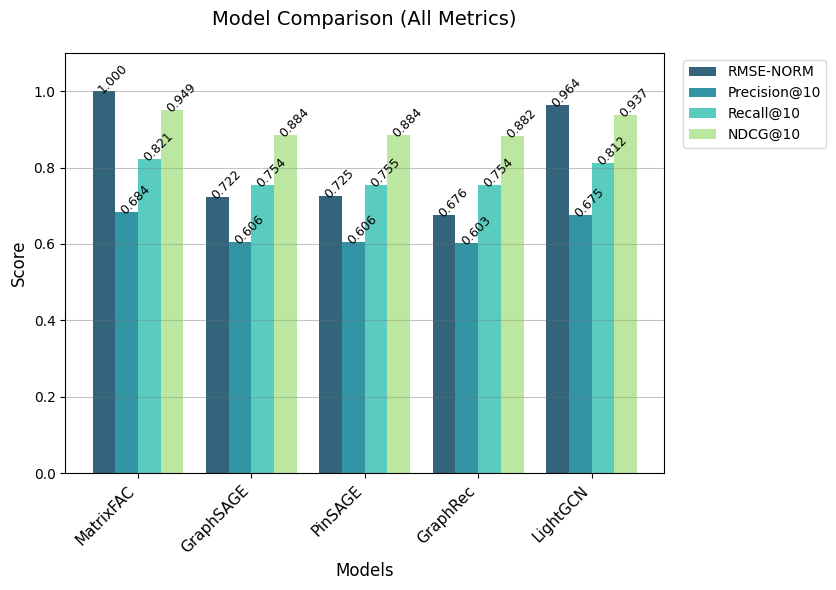

In [32]:
colors = ['#003D5B', '#00798C', '#30BEB0', '#ABE188']

fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(models))
w = 0.2

# Plot bars with soft pastel colors and subtle edge
bars1 = ax.bar(x - 1.5*w, rmse_norm, w, label='RMSE-NORM', color=colors[0], alpha=0.8)
bars2 = ax.bar(x - 0.5*w, precision, w, label='Precision@10', color=colors[1], alpha=0.8)
bars3 = ax.bar(x + 0.5*w, recall, w, label='Recall@10', color=colors[2], alpha=0.8)
bars4 = ax.bar(x + 1.5*w, ndcg, w, label='NDCG@10', color=colors[3], alpha=0.8)

# Add value labels with reduced boldness
def add_value_labels(bars, values):
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() + 0.02, height + 0.02,
                f'{val:.3f}', ha='center', va='bottom', fontsize=9, fontweight='normal',
                rotation=45, rotation_mode='anchor'
                )

add_value_labels(bars1, rmse_norm)   # Show actual RMSE
add_value_labels(bars2, precision)
add_value_labels(bars3, recall)
add_value_labels(bars4, ndcg)

# Style the plot with reduced font boldness
ax.set_title('Model Comparison (All Metrics)', fontsize=14, fontweight='normal', pad=20)
ax.set_xlabel('Models', fontsize=12, fontweight='normal')
ax.set_ylabel('Score', fontsize=12, fontweight='normal')
ax.set_xticks(x)
ax.set_xticklabels(models, rotation=45, ha='right', fontsize=11, fontweight='normal')
ax.grid(axis='y', alpha=0.3, linestyle='-', color='gray')
ax.set_ylim(0, 1.10)

# Set background to white
ax.set_facecolor('white')
fig.patch.set_facecolor('white')

# Add legend on the right
legend = ax.legend(loc='upper left', bbox_to_anchor=(1.02, 1), fontsize=10, frameon=True, 
                   title_fontsize=10, prop={'weight': 'normal'})
legend.get_frame().set_edgecolor('lightgray')
legend.get_frame().set_linewidth(1)

# Add subtle horizontal lines
for y in ax.get_yticks():
    ax.axhline(y=y, color='lightgray', linestyle='-', linewidth=0.5, zorder=0)

plt.tight_layout(rect=[0, 0, 0.85, 1])
plt.savefig('../docs/eval_stack.png', dpi=300)
plt.show()

In [33]:

from typing import List, Tuple, Optional, Dict
import logging

### Movies Recommender Engine

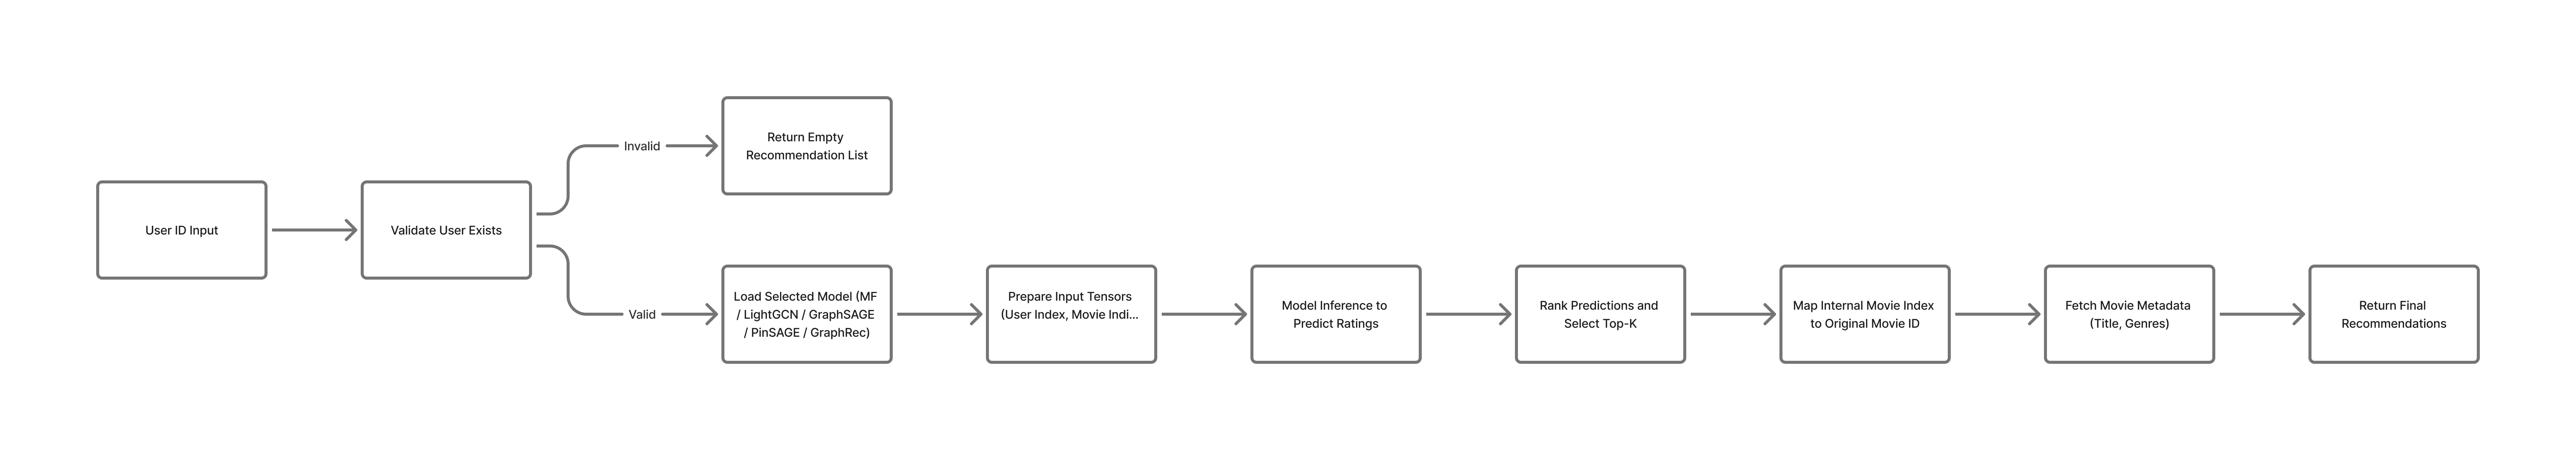

In [34]:
from IPython.display import Image, display

display(Image(filename='../docs/Movie Recommender System Architecture.png'))

- first it validates the user ID; if invalid, it returns an empty list. Otherwise, it loads a recommendation model, predicts ratings for movies, ranks them, maps indices to original IDs, fetches metadata, and returns the final top-K recommendations.

In [50]:
class MovieRecommendationSystem:

    def __init__(self, model_path_prefix: str = "../models/"):
        """Initialize the recommendation system"""
        self.model_path_prefix = model_path_prefix
        self._setup_logging()
        self._validate_data()
    
    def _setup_logging(self):
        """Setup logging for the recommendation system."""
        logging.basicConfig(level=logging.INFO)
        self.logger = logging.getLogger(__name__)
    
    def _validate_data(self):
        """Validate that required data structures exist."""
        required_vars = ['movies', 'ratings', 'user_mapping', 'movie_mapping', 
                        'num_users', 'num_movies', 'data', 'edge_index_proper']
        missing = [var for var in required_vars if var not in globals()]
        if missing:
            raise ValueError(f"Missing required data: {missing}")
    
    def get_movie_info(self, movie_id: int) -> Optional[Dict]:
        """Get detailed information about a specific movie"""
        movie_row = movies[movies['movieId'] == movie_id]
        if len(movie_row) > 0:
            return {
                'movie_id': int(movie_row.iloc[0]['movieId']),
                'title': movie_row.iloc[0]['title'],
                'genres': movie_row.iloc[0]['genres']
            }
        return None
    
    def _validate_user(self, user_id: int) -> bool:
        """Validate if user exists in training data"""
        return user_id in user_mapping
    
    def _load_model(self, model_name: str):
        """Load a specific model from saved file"""
        try:
            if model_name == 'mf':
                model = MatrixFactorization(num_users, num_movies, embed_dim=64)
                path = f'{self.model_path_prefix}best_mf_model.pth'
            elif model_name == 'lightgcn':
                model = LightGCN_Rating(num_users, num_movies, embed_dim=64, num_layers=3)
                path = f'{self.model_path_prefix}best_rating_lightgcn_model.pth'
            elif model_name == 'graphsage':
                model = GraphSAGE_Recommender(input_dim=data.x.shape[1], dropout_rate=0.3)
                path = f'{self.model_path_prefix}best_graphsage_model.pth'
            elif model_name == 'pinsage':
                model = SimplePinSAGE(input_dim=data.x.shape[1], dropout_rate=0.3)
                path = f'{self.model_path_prefix}best_simple_pinsage_model.pth'
            elif model_name == 'graphrec':
                model = GraphRec(input_dim=data.x.shape[1], hidden_dim=64)
                path = f'{self.model_path_prefix}best_graphrec_model.pth'
            else:
                raise ValueError(f"Unknown model: {model_name}")
            
            model.load_state_dict(torch.load(path, weights_only=True))
            model.eval()
            return model
            
        except Exception as e:
            raise ValueError(f"Error loading {model_name} model: {str(e)}")
    
    def recommend_for_user(self, user_id: int, model_name: str = 'mf', 
                          n_recommendations: int = 10) -> List[Tuple[int, str, float]]:
       
        # Validate user
        if not self._validate_user(user_id):
            self.logger.warning(f"User {user_id} not found in training data")
            return []
        
        # Load model
        model = self._load_model(model_name)
        
        # Get recommendations based on model type
        user_idx = user_mapping[user_id]
        
        with torch.no_grad():
            if model_name == 'mf':
                all_movie_indices = torch.arange(num_movies)
                pred = model(torch.tensor([user_idx]).repeat(num_movies), all_movie_indices)
            elif model_name == 'lightgcn':
                all_movie_indices = torch.arange(num_movies)
                pred = model(edge_index_proper, 
                            torch.tensor([user_idx]).repeat(num_movies), 
                            all_movie_indices)
            elif model_name in ['graphsage', 'pinsage']:
                all_movie_indices = torch.arange(num_movies) + num_users
                pred = model(data.x, data.edge_index, 
                            torch.tensor([user_idx]).repeat(num_movies), all_movie_indices)
            elif model_name == 'graphrec':
                all_movie_indices = torch.arange(num_movies)
                pred = model(data.x, data.edge_index, 
                            torch.tensor([user_idx]).repeat(num_movies), all_movie_indices)
        
        # Get top recommendations
        top_scores, top_movie_indices = torch.topk(pred, n_recommendations)
        
        recommendations = []
        for score, movie_idx_tensor in zip(top_scores, top_movie_indices):
            original_movie_id = list(movie_mapping.keys())[movie_idx_tensor.item()]
            movie_info = self.get_movie_info(original_movie_id)
            if movie_info:
                recommendations.append((
                    original_movie_id, 
                    movie_info['title'], 
                    round(score.item(), 3)
                ))
        
        return recommendations
    
    def recommend_popular(self, n_recommendations: int = 10, 
                         min_ratings: int = 50, 
                         genre_filter: Optional[str] = None) -> List[Tuple[int, str, float, str]]:

        # Calculate movie statistics
        movie_stats = ratings.groupby('movieId').agg({
            'rating': ['mean', 'count']
        }).reset_index()
        
        movie_stats.columns = ['movieId', 'avg_rating', 'rating_count']
        movie_stats = movie_stats[movie_stats['rating_count'] >= min_ratings]
        
        # Apply genre filter if specified
        if genre_filter:
            movie_stats = movie_stats.merge(
                movies[['movieId', 'genres']], 
                on='movieId', 
                how='inner'
            )
            movie_stats = movie_stats[
                movie_stats['genres'].str.contains(genre_filter, case=False, na=False)
            ]
        
        # Calculate weighted rating (IMDB formula)
        C = movie_stats['rating_count'].mean()  # Mean number of ratings
        m = movie_stats['avg_rating'].mean()    # Mean rating
        
        movie_stats['popularity_score'] = (
            (movie_stats['rating_count'] / (movie_stats['rating_count'] + C)) * movie_stats['avg_rating'] +
            (C / (movie_stats['rating_count'] + C)) * m
        )
        
        # Sort by popularity score
        top_movies = movie_stats.sort_values('popularity_score', ascending=False)
        
        # Format results
        recommendations = []
        for _, row in top_movies.head(n_recommendations).iterrows():
            movie_info = self.get_movie_info(int(row['movieId']))
            if movie_info:
                recommendations.append((
                    int(row['movieId']),
                    movie_info['title'],
                    round(row['popularity_score'], 3),
                    movie_info['genres']
                ))
        
        return recommendations
    
    def search_movies(self, query: str, top_k: int = 10) -> List[Tuple[int, str, str]]:
    
        query = query.lower().strip()
        
        matches = []
        for _, row in movies.iterrows():
            movie_id = row['movieId']
            title = row['title']
            genres = row['genres']
            
            if query in title.lower() or query in genres.lower():
                matches.append((movie_id, title, genres))
        
        return matches[:top_k]
    
    def recommend_by_genre(self, user_id: int, genre: str, 
                          model_name: str = 'mf', 
                          n_recommendations: int = 10) -> List[Tuple[int, str, float, str]]:
 
        # Get more recommendations than needed to filter by genre
        all_recommendations = self.recommend_for_user(
            user_id, model_name, n_recommendations * 3
        )
        
        # Filter by genre
        genre_recommendations = []
        for movie_id, title, rating in all_recommendations:
            movie_info = self.get_movie_info(movie_id)
            if movie_info and genre.lower() in movie_info['genres'].lower():
                genre_recommendations.append((
                    movie_id, 
                    title, 
                    rating, 
                    movie_info['genres']
                ))
            
            if len(genre_recommendations) >= n_recommendations:
                break
        
        return genre_recommendations
    
    def find_similar_by_coratings(self, movie_id: int, 
                                  n_similar: int = 10,
                                  min_common_users: int = 5) -> List[Tuple[int, str, int, str, float]]:

        # Get users who rated this movie
        movie_raters = ratings[ratings['movieId'] == movie_id]['userId'].values
        
        if len(movie_raters) == 0:
            return []
        
        # Get all ratings from these users
        other_ratings = ratings[ratings['userId'].isin(movie_raters)]
        
        # Count co-occurrences
        corated = other_ratings.groupby('movieId').size().sort_values(ascending=False)
        corated = corated[corated.index != movie_id]  # Exclude the movie itself
        corated = corated[corated >= min_common_users]  # Filter by minimum common users
        
        # Calculate similarity score (Jaccard-like)
        total_raters = len(movie_raters)
        
        similar = []
        for mid, count in corated.head(n_similar).items():
            movie_info = self.get_movie_info(mid)
            if movie_info:
                # Simple similarity: ratio of common users
                similarity_score = count / total_raters
                similar.append((
                    mid, 
                    movie_info['title'], 
                    int(count),
                    movie_info['genres'],
                    round(similarity_score, 3)
                ))
        
        return similar
    
    def compare_models(self, user_id: int, 
                      models: List[str] = ['mf', 'lightgcn'],
                      n_recommendations: int = 5) -> Dict[str, List[Tuple[int, str, float]]]:

        results = {}
        
        for model_name in models:
            try:
                recs = self.recommend_for_user(user_id, model_name, n_recommendations)
                results[model_name] = recs
            except Exception as e:
                self.logger.error(f"Error with {model_name}: {str(e)}")
                results[model_name] = []
        
        return results
    
    
    def get_similar_movies_by_title(self, search_term: str, n_similar: int = 10, 
                                    min_common_users: int = 5) -> List[Tuple[int, str, int, str, float]]:
  
        matches = self.search_movies(search_term, top_k=5)
        
        if not matches:
            self.logger.warning(f"No movies found matching '{search_term}'")
            return []
        
        if len(matches) > 1:
            print(f"Multiple matches found for '{search_term}':")
            for movie_id, title, genres in matches:
                print(f"  {movie_id}: {title} [{genres}]")
            return []
        
        sample_movie = matches[0][0]
        return self.find_similar_by_coratings(sample_movie, n_similar, min_common_users)
    

### Testing

In [51]:
# Initialize the system
recommender = MovieRecommendationSystem()

#### UserID Validation

In [90]:
sample_user = 6

- check if the user exist

In [ ]:
if sample_user not in user_mapping:
    print(f" ERROR: User {sample_user} not found in the data")
    print(f"Available users: {min(user_mapping.keys())} to {max(user_mapping.keys())}")
    sample_user = list(user_mapping.keys())[0]  # Fallback to first user
    print(f"Using default user: {sample_user}")
else:
    print(f"\n [._.] User ID = {sample_user} is available")


 [._.] User ID = 6 is available


In [54]:
# [1, 6, 31, 40, 53] 

# 'mf', 'lightgcn', 'graphsage', 'pinsage', 'graphrec'

#### Personalized Recommendations

- input any of these models:  `'mf'` `'lightgcn'` `'graphsage'` `'pinsage'` `'graphrec'`

In [92]:
model_name= 'lightgcn'  # select one of the 5 models

n_recommendations=10    # number of movies to recommend based on model's predicted rating/rankings

print("\n PERSONALIZED RECOMMENDATIONS")

print(f"Recommendations for User {sample_user}:")

recs = recommender.recommend_for_user(sample_user, model_name, n_recommendations)
for movie_id, title, rating in recs:
    print(f" >> {title} (Predicted Rating: {rating})")


 PERSONALIZED RECOMMENDATIONS
Recommendations for User 6:
 >> Shawshank Redemption, The (1994) (Predicted Rating: 4.488)
 >> Band of Brothers (2001) (Predicted Rating: 4.334)
 >> Planet Earth (2006) (Predicted Rating: 4.323)
 >> Planet Earth II (2016) (Predicted Rating: 4.322)
 >> Dark Knight, The (2008) (Predicted Rating: 4.284)
 >> Matrix, The (1999) (Predicted Rating: 4.28)
 >> Inception (2010) (Predicted Rating: 4.273)
 >> Intouchables (2011) (Predicted Rating: 4.252)
 >> Blue Planet II (2017) (Predicted Rating: 4.24)
 >> Life Is Beautiful (La Vita è bella) (1997) (Predicted Rating: 4.236)


#### Popular Movies Ranked by Weighted Popularity Score (IMDB Formula)

- shows globally popular movies (non-personalized, model-free)

$$
WR = \frac{v}{v + m} R + \frac{m}{v + m} C
$$

Where:

- **R** = average rating for the movie  
- **v** = number of ratings for the movie  
- **m** = minimum votes required to be listed (or a proxy such as mean number of ratings)  
- **C** = the mean vote/rating across the whole dataset

In [56]:
# Popular Movies
print("\n POPULAR MOVIES")
popular = recommender.recommend_popular(n_recommendations=10)
print("Top popular movies:")
for movie_id, title, score, genres in popular:
    print(f">> {title} (Score: {score}) [{genres}]")


 POPULAR MOVIES
Top popular movies:
>> Shawshank Redemption, The (1994) (Score: 4.345) [Crime|Drama]
>> Godfather, The (1972) (Score: 4.232) [Crime|Drama]
>> Usual Suspects, The (1995) (Score: 4.188) [Crime|Mystery|Thriller]
>> Schindler's List (1993) (Score: 4.174) [Drama|War]
>> Fight Club (1999) (Score: 4.168) [Action|Crime|Drama|Thriller]
>> Godfather: Part II, The (1974) (Score: 4.157) [Crime|Drama]
>> Pulp Fiction (1994) (Score: 4.156) [Comedy|Crime|Drama|Thriller]
>> 12 Angry Men (1957) (Score: 4.114) [Drama]
>> One Flew Over the Cuckoo's Nest (1975) (Score: 4.113) [Drama]
>> Matrix, The (1999) (Score: 4.11) [Action|Sci-Fi|Thriller]


#### Genre-Specific Recommendations

- generates recommendations using collaborative filtering

In [ ]:
genre_spec = 'Action'

print("\n GENRE-SPECIFIC RECOMMENDATIONS")
genre_recs = recommender.recommend_by_genre(sample_user,genre_spec, n_recommendations=10)
print(f"Action movies for User {sample_user}:")
for movie_id, title, rating, genres in genre_recs:
    print(f"  >> {title} (Rating: {rating}) [{genres}]")



 GENRE-SPECIFIC RECOMMENDATIONS
Action movies for User 53:
  >> Good, the Bad and the Ugly, The (Buono, il brutto, il cattivo, Il) (1966) (Rating: 4.398) [Action|Adventure|Western]
  >> Seven Samurai (Shichinin no samurai) (1954) (Rating: 4.364) [Action|Adventure|Drama]
  >> Raiders of the Lost Ark (Indiana Jones and the Raiders of the Lost Ark) (1981) (Rating: 4.33) [Action|Adventure]


####  Movies Search 

- model free, it is a text-based similarity matching

In [ ]:
keyword = "Toy"

print("\n MOVIE SEARCH")
search_results = recommender.search_movies(keyword, top_k=10)
print(f"Search results for: {keyword}")
for movie_id, title, genres in search_results:
    print(f">> {title} [{genres}]")


 MOVIE SEARCH
Search results for: Toy
>> Toy Story (1995) [Adventure|Animation|Children|Comedy|Fantasy]
>> Babes in Toyland (1961) [Children|Fantasy|Musical]
>> Toys (1992) [Comedy|Fantasy]
>> Toy Story 2 (1999) [Adventure|Animation|Children|Comedy|Fantasy]
>> Toy, The (1982) [Comedy]
>> Toy Soldiers (1991) [Action|Drama]
>> Toy Story 3 (2010) [Adventure|Animation|Children|Comedy|Fantasy|IMAX]
>> Toy Story 4 (2019) [Adventure|Animation|Children|Comedy]


####  Similar Movies (co-rating based)

- shows movies similar to the `sample_movie` based on co-rating patterns (collaborative filtering)

In [78]:
sample_movie = "Jumanji"

print(f"COMPARING SIMILARITY for: '{sample_movie}'")

matches = recommender.search_movies(sample_movie, top_k=1)
if matches:
    movie_id = matches[0][0]
    
    # Co-rating similarity
    corating_similar = recommender.find_similar_by_coratings(movie_id, n_similar=10)
    for rank, (mid, title, common, genres, sim) in enumerate(corating_similar, 1):
        print(f"{rank:>2}. {title:<50} | {common:>4} users | similarity: {sim:.3f}")

COMPARING SIMILARITY for: 'Jumanji'
 1. Forrest Gump (1994)                                | 2076 users | similarity: 0.824
 2. Jurassic Park (1993)                               | 2025 users | similarity: 0.804
 3. Pulp Fiction (1994)                                | 1845 users | similarity: 0.732
 4. Shawshank Redemption, The (1994)                   | 1774 users | similarity: 0.704
 5. Silence of the Lambs, The (1991)                   | 1754 users | similarity: 0.696
 6. Lion King, The (1994)                              | 1741 users | similarity: 0.691
 7. Terminator 2: Judgment Day (1991)                  | 1706 users | similarity: 0.677
 8. Toy Story (1995)                                   | 1686 users | similarity: 0.669
 9. Braveheart (1995)                                  | 1640 users | similarity: 0.651
10. Aladdin (1992)                                     | 1639 users | similarity: 0.650


#### Movies Recommendation (All Models)

In [82]:
print("\n MODEL COMPARISON")
all_models = ['mf', 'lightgcn', 'graphsage', 'pinsage', 'graphrec']
comparison = recommender.compare_models(sample_user, models=all_models, n_recommendations=3)
for model_name, recs in comparison.items():
    print(f"\n{model_name.upper()}:")
    if recs:
        for movie_id, title, rating in recs:
            print(f"  >> {title} (Rating: {rating})")
    else:
        print(f" No recommendations (model may not be available)")


 MODEL COMPARISON

MF:
  >> Twin Peaks (1989) (Rating: 4.491)
  >> Godfather: Part II, The (1974) (Rating: 4.469)
  >> Underground (1995) (Rating: 4.439)

LIGHTGCN:
  >> Band of Brothers (2001) (Rating: 4.49)
  >> Planet Earth (2006) (Rating: 4.489)
  >> Planet Earth II (2016) (Rating: 4.485)

GRAPHSAGE:
  >> Whole Nine Yards, The (2000) (Rating: 3.871)
  >> Fish Tank (2009) (Rating: 3.856)
  >> Ringer, The (2005) (Rating: 3.851)

PINSAGE:
  >> Unfinished Life, An (2005) (Rating: 3.836)
  >> Into the Wild (2007) (Rating: 3.762)
  >> Pain and Glory (2019) (Rating: 3.755)

GRAPHREC:
  >> Headhunters (Hodejegerne) (2011) (Rating: 4.127)
  >> My Neighbor Totoro (Tonari no Totoro) (1988) (Rating: 3.789)
  >> Sheltering Sky, The (1990) (Rating: 3.771)
